In [39]:
##Initialize

import numpy as np
import fileinput
import math
import inspect, os
from sys import argv
import time
import scipy.integrate as spi
import pandas as pd
from sys import argv
import numpy as np
import scipy as sp

##For the plots##
import math, os
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MultipleLocator
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib.colors as mcolors
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'

## 3D diffusion to find the cell ##
### With 3D diffusion only ###
If we consider a spherical cell of radius $a$ in a medium where molecules X can diffuse in 3D with a diffusion coefficient $D_{3D}$. We first consider that the concentration of X arises from diffusion in the medium. In this case, the Fokker-Planck equation is:

\begin{equation}
    D_{3D} \nabla^2c = \frac{\partial c}{\partial t}
\end{equation}

The current of molecules reaching the cell is obtained by considering the steady-state $D_{3D} \nabla^2c = 0$. Considering the isotropy of the system, the continuity condition $c = 0$ at $r=a$ and the limit $c = c_{\infty}$ at $r\to+\infty$. Then:

\begin{equation*}
    c(r)=c_{\infty}\left(1-\frac{a}{r}\right)
\end{equation*}

Thus the diffusion current given by Fick's law, $\bm{j}=-D_{3D}\nabla c$, is given by:

\begin{equation*}
    \bm{j} = c_{\infty}D_{3D}\frac{a}{r^2} \bm{e_r}
\end{equation*}

The integration of the current over the cell's surface (spherical object) yields:

\begin{equation*}
    \oiint \bm{j}\cdot\bm{dS} = 4\pi ac_{\infty}D_{3D}
\end{equation*}

For a disk-like object of radius $s$, we get $\bm{j} = c_{\infty}D_{3D}\frac{a}{r^2}$ and:

\begin{equation*}
    J_{tot} = 4 s c_{\infty}D_{3D}
\end{equation*}

From this we can deduce the current of molecules reaching one of the $N$ disk-like receptors of radius $s$ on the cell of radius $a$ using 3D diffusion:

\begin{equation*}
    J = 4 \pi a c_{\infty}D_{3D} \frac{Ns}{Ns+\pi a}
\end{equation*}

### With 2D diffusion on the membrane ###
If we now consider that once the molecule is close enough to the cell surface, it can bind to the surface and diffuse in 2D until it reaches the receptors. The 2D diffusion on the cell surface is more efficient than 3D diffusion only to find the receptors. The mean time between adorption on the surface and capture by the receptors has been found to be:

\begin{equation*}
    \bar{t} = \left(\frac{1.1 a^2}{N D_{2D}}\right) \ln\left(\frac{1.2a^2}{Ns^2}\right)
\end{equation*}

## Monte-Carlo Simulation of the 2D diffusion on the cell's surface ##

Here we compute the time to capture as a function of the number of receptors on the cell, using a Monte-Carlo simulation. We vary the typical speed of the displacement of the molecule for a given time interval (which is equivalent to varying the diffusion coefficient) on the sphere and start by supposing that the receptors are fixed. We start by defining a class to estimate the average time to capture.

In [40]:
class montecarlo:
    def __init__(self, n_simu, N_arr, s_arr, a_arr, moving_rec=False):
        self.n_simu = n_simu #Number of simulations
        self.N_arr = N_arr #Array with number of receptors
        self.s_arr = s_arr #Array with typical sizes of the receptors (radius). Typically 10 Angstrom according to the text.
        self.a_arr = a_arr #Array with radius of the cell. Typically 1 µm according to the text.
        self.mol_rad = 5.E-8
        self.dt = 1.E-5
        self.D_rec = 5.E-10
        self.D_mol = 5.E-10
        self.v_rec = np.sqrt(self.D_rec/self.dt)
        self.v_mol = np.sqrt(self.D_mol/self.dt)
        self.moving_rec = moving_rec
        self.diff_coef_mol = self.v_mol**2 * self.dt
        self.diff_coef_rec = self.v_rec**2 * self.dt

    def distance_sphere(self,pos1,pos2):
        #return the distance on the sphere of two positions
        if pos1[0] == pos1[0]:
            a=pos1[0]
            theta1,phi1 = pos1[1], pos1[2]
            theta2,phi2 = pos2[1], pos2[2]
            return np.abs(a*np.arccos(np.cos(theta1)*np.cos(theta2)+np.sin(theta1)*np.sin(theta2)*np.cos(phi2-phi1)))

    def rand_pos_recep(self,a,N):
        return np.array([[a, np.random.rand()*np.pi, np.random.rand()*2*np.pi] for n in range(N)]) #Pick N random positions on the sphere

    def rand_pos(self,a):
        return np.array([a, np.random.rand()*np.pi, np.random.rand()*2*np.pi])
    
    def rand_disp(self, a, v):
        disp_theta = (2*np.random.rand()-1.)*v*self.dt/a
        disp_theta = disp_theta - np.pi*int(abs(disp_theta/np.pi))
        disp_phi = (2*np.random.rand()-1.)*v*self.dt/a
        disp_phi = disp_phi - 2.*np.pi*int(abs(disp_phi/(2.*np.pi)))
        return np.array([0., disp_theta, disp_phi])

    def time_capture(self,a,N,s):
        #Estimate the time before capture from 2D diffusion on the surface
        t=0.
        pos_recep = self.rand_pos_recep(a,N)
        pos_mol = self.rand_pos(a)
        dist_arr = [self.distance_sphere(pos_mol,pos) for pos in pos_recep]
        min = np.min(dist_arr)
        while min>s+self.mol_rad:
            if self.moving_rec:
                disp_rec = [self.rand_disp(a,self.v_rec) for n in range(N)]
                pos_recep = [pos_recep[n] + disp_rec[n] for n in range(N)]
                disp_mol = self.rand_disp(a,self.v_mol)
                pos_mol += disp_mol
            else:
                disp_mol = self.rand_disp(a,self.v_mol)
                pos_mol += disp_mol
            dist_arr = [self.distance_sphere(pos_mol,pos) for pos in pos_recep]
            min = np.min(dist_arr)
            t = t + self.dt
        return t
    
    def time_capture_mean(self,a,N,s):
        t=0
        for i in range(self.n_simu):
            tcapt = self.time_capture(a,N,s)
            t = t+tcapt
        return t/self.n_simu

In the following we compare a Monte-Carlo simulation of this process to the theoretical predictions of the article. Here we use a spherical geometry contrary to the original article where the simulation and the proof of the formula yielding $\bar{t}$ are done on a square lattice.

[9.39526252e-11]


/tmp/ipykernel_159343/2540106636.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


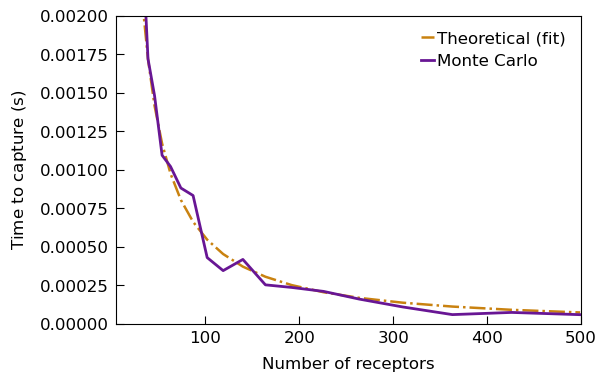

In [41]:
a=1.E-6
s=1.E-8

##Plot the time to capture for fixed receptors##
log_rec = np.logspace(np.log10(5),np.log10(500), num=30)
rec_list = [int(n) for n in log_rec]
simu_fix = montecarlo(100,rec_list,[s],[a],moving_rec=False)

##Initialize figure##
current_directory = os.getcwd()
# Create a figure and axis  
fig, ax = plt.subplots()
# Set axes
ax.set_xlabel(r'Number of receptors',fontsize=12,labelpad=8)
ax.set_ylabel(r'Time to capture $\left(\rm{s}\right)$',fontsize=12,labelpad=8)
ax.spines['bottom'].set_position(('data', 0.))
ax.spines['left'].set_position(('data', 5.))
ax.set_xlim(5., 500.)
ax.set_ylim(0.0, 2.E-3)

##Results##
time_arr_fix = [simu_fix.time_capture_mean(a,N,s) for N in simu_fix.N_arr]
##Save results as .csv##
fix = pd.DataFrame(time_arr_fix)
fix.to_csv('time_array_fixed.csv', index=False)
##Read from the .csv##
time_arr_fix = np.array(pd.read_csv('time_array_fixed.csv', header=None))[1:,0]

##Theoretical predictions##
D = simu_fix.diff_coef_mol
def mean_t(a,s,N,D):
    return (1.1*a**2/(N*D))*np.log(1.2*a**2/(N*s**2))
def func(N,D):
    return mean_t(a,s,N,D)
##Fit the simulation##
array_N = np.array(simu_fix.N_arr)
popt, pcov = curve_fit(func, array_N, time_arr_fix, p0=(1.E-11))
fitted_curve = [func(N, *popt) for N in array_N]
print(popt)
theo_arr = [mean_t(a,s,N,D) for N in simu_fix.N_arr]

##Plot##
color_arr = ['#681694','#166094','#169431','#c98210']
ax.plot(array_N, fitted_curve, alpha = 1.,c=color_arr[3],ls='-.',lw=1.8, label=r'Theoretical (fit)')
ax.plot(simu_fix.N_arr, time_arr_fix, c=color_arr[0], label=r'Monte Carlo', lw=2, zorder=2)
#ax.plot(simu_fix.N_arr, theo_arr, c=color_arr[1], label=r'Theoretical', lw=2, zorder=2)
# Adjust tick positions and labels
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=5)
##Save figure##
ax.tick_params(labelsize=12,direction='in',which='minor',bottom=True, top=False, left=True, right=False,length=3 ) 
ax.tick_params(labelsize=12,direction='in',which='major',bottom=True, top=False, left=True, right=False,length=6 )
ax.legend(fancybox=True, shadow=True, ncol=1, fontsize=12,columnspacing=1.,scatterpoints=1,handletextpad=0.2,handlelength=0.8,frameon=False)
os.chdir(current_directory)
name_file_save='time_cap'+'.pdf'
fig.set_size_inches(6, 4)
fig.savefig(name_file_save, dpi=300, bbox_inches="tight",transparent=True)
os.chdir(current_directory)
fig.show()

We can now compare the average time to capture with fixed receptors or moving receptors able to diffuse on the surface of the cell. For two diffusing objects (with diffusion coefficients $D_0$ and $D_1$), if we consider first that the surface of the sphere is large enough to assimilate the problem to the diffusion on infinite plane, the probability for the two objects to find each other (within a surface $s^2$) at $t$ is:

\begin{equation*}
\begin{split}
    P_{contact}(\bm{R}_0,\bm{R}_1,t) 10.&= \int_{S} \bm{d^2r} \int_{r' < s} \bm{d^2r'} \left(\frac{2}{2\pi}\right)^2\left(\frac{1}{D_0 D_1 t^2}\right)e^{-\frac{|\bm{r}-\bm{R}_0|^2}{D_0 t}}e^{-\frac{|\bm{r}+\bm{r'}-\bm{R}_1|^2}{D_1 t}}
    \\ & \simeq \int_{S} \bm{d^2r} s^2 \left(\frac{2}{2\pi}\right)^2\left(\frac{1}{D_0 D_1 t^2}\right)e^{-\frac{|\bm{r}-\bm{R}_0|^2}{D_0 t}}e^{-\frac{|\bm{r}-\bm{R}_1|^2}{D_1 t}}
\end{split}
\end{equation*}

Therefore, the most probable time of contact is given by solving:

\begin{equation*}
    \frac{\partial P_{contact}(\bm{R}_0,\bm{R}_1,t)}{\partial t} = 0
\end{equation*}

/home/barnabe/anaconda3/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/tmp/ipykernel_159343/950092869.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


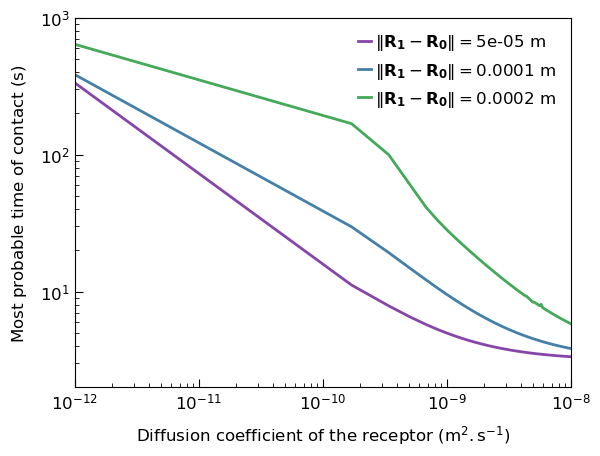

In [42]:
##Plot of the theoretical probability for two diffusing objects to find each other##

def gauss2D(r,sigma):
    dist = np.linalg.norm(r)**2
    exp = np.exp(-2.*dist/(2.*(sigma**2)))
    return exp*(2./(2.*np.pi*(sigma**2)))

def proba_contact(D0,D1,R0,R1,s,t):
    sigma0=np.sqrt(D0*t)
    sigma1=np.sqrt(D1*t)
    def func(r,rprime):
        res = gauss2D(r-R0,sigma0)*gauss2D(r+rprime-R1,sigma1)
        return res
    def integrand2(x,y):
        r = np.array([x,y])
        rprime=[0,0]
        res = (s**2)*func(r,rprime)
        return res
    result, _ = spi.dblquad(integrand2, -1.E-2, 1.E-2, -1.E-2, 1.E-2)
    return result
    
D_recep_array = np.linspace(1.E-12, 1.E-8, 60)
D_mol = 1.E-10
R0_arr = np.array([[0,0],[0,0],[0,0]])
R1_arr = np.array([[5.E-5,0.],[1.E-4,0.],[2.E-4,0.]])
s=1.E-8

#t_arr=np.linspace(1.E-4,1.E1,100)
#proba_arr=[proba_contact(D_mol,D_mol,R0,R1,s,t) for t in t_arr]
#plt.plot(t_arr,proba_arr)
#plt.show()

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Diffusion coefficient of the receptor $\left(\rm{m^2.s^{-1}}\right)$',fontsize=12,labelpad=8)
ax.set_ylabel(r'Most probable time of contact $\left(\rm{s}\right)$',fontsize=12,labelpad=8)
ax.spines['bottom'].set_position(('data', 2.E0))
ax.spines['left'].set_position(('data', 1.E-12))
ax.set_xlim(1.E-12, 1.E-8)
ax.set_ylim(2.E0, 1.E3)
ax.tick_params(labelsize=12,direction='in',which='minor',bottom=True, top=False, left=True, right=False,length=3 ) 
ax.tick_params(labelsize=12,direction='in',which='major',bottom=True, top=False, left=True, right=False,length=6 )
        

color_arr = ['#681694','#166094','#169431','#c98210']

for n in range(R0_arr.size//2):
    R0, R1 = R0_arr[n], R1_arr[n]
    title = r'$\| \mathbf{R_1} - \mathbf{R_0} \| = $' + str(R1_arr[n,0]) + r' m'
    mp_time_array=[]
    for D1 in D_recep_array:
        def proba_contact_time(t):
            return proba_contact(D_mol, D1, R0, R1, s, t)
        mp_time = minimize_scalar(lambda x: -proba_contact_time(x), bounds=(1.E-6, 1.E6), method='bounded').x
        mp_time_array.append(mp_time)
    mp_time_array = np.array(mp_time_array)
    ax.plot(D_recep_array,mp_time_array, lw=2., alpha=0.8, c=color_arr[n], label=title)
    ax.legend(fancybox=True, shadow=True, ncol=1, fontsize=12,columnspacing=1.,scatterpoints=1,handletextpad=0.2,handlelength=0.8,frameon=False)
fig.show()

This result suggests that the most probable time of contact between the receptor and the molecule decreases when the diffusion of the receptor increases for different starting distances between the diffusing objects. Therefore we can expect a smaller time to capture with diffusing receptors.

We also see that the slope changes when the diffusion coefficient of the receptors becomes higher than that of the diffusing molecule.

[9.39524319e-11]


/tmp/ipykernel_159343/2685890520.py:72: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


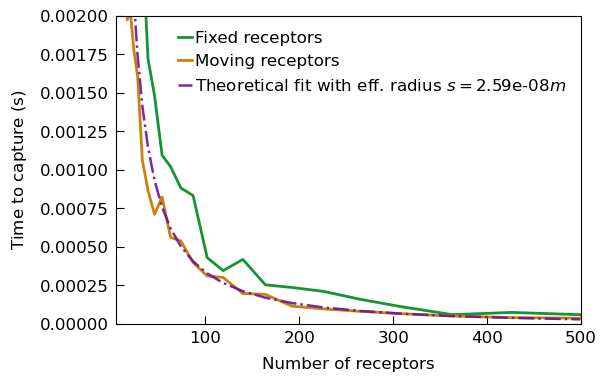

In [43]:
a=1.E-6
s=1.E-8

##Plot the time to capture for moving receptors##
log_rec = np.logspace(np.log10(5),np.log10(500), num=30)
rec_list = [int(n) for n in log_rec]
simu_mov = montecarlo(100,rec_list,[s],[a],moving_rec=True)

##Initialize figure##
current_directory = os.getcwd()
# Create a figure and axis  
fig, ax = plt.subplots()
# Set axes
ax.set_xlabel(r'Number of receptors',fontsize=12,labelpad=8)
ax.set_ylabel(r'Time to capture $\left(\rm{s}\right)$',fontsize=12,labelpad=8)
ax.spines['bottom'].set_position(('data', 0.))
ax.spines['left'].set_position(('data', 5.))
ax.set_xlim(5., 500.)
ax.set_ylim(0.0, 2.E-3)

##Results##
time_arr_mov = [simu_mov.time_capture_mean(a,N,s) for N in simu_mov.N_arr]
##Save results as .csv##
mov = pd.DataFrame(time_arr_mov)
mov.to_csv('time_array_moving.csv', index=False)
##Read from the .csv##
time_arr_fix = np.array(pd.read_csv('time_array_fixed.csv', header=None))[1:,0]
time_arr_mov = np.array(pd.read_csv('time_array_moving.csv', header=None))[1:,0]

##Theoretical predictions##
D = simu_mov.diff_coef_mol
def mean_t(a,s,N,D):
    return (1.1*a**2/(N*D))*np.log(1.2*a**2/(N*s**2))
def func_fix(N,D):
    return mean_t(a,s,N,D)
##Fit the simulations##
## Fixed ##
array_N = np.array(simu_fix.N_arr)
mask = (array_N < 400.)
popt, pcov = curve_fit(func_fix, array_N[mask], time_arr_fix[mask], p0=(1.E-10))
print(popt)
eff_D=popt
## Moving ##
def func(N,s):
    return mean_t(a,s,N,eff_D)
array_N = np.array(simu_mov.N_arr)
mask = (100. < array_N) & (array_N < 300.)
popt, pcov = curve_fit(func, array_N[mask], time_arr_mov[mask], p0=(1.E-8))
eff_s=popt
theo_arr = [mean_t(a,eff_s,N,eff_D) for N in simu_mov.N_arr]

##Plot##
color_arr = ['#681694','#166094','#169431','#c98210']
ax.plot(array_N , time_arr_fix, c=color_arr[2], label=r'Fixed receptors', lw=2, zorder=2)
ax.plot(array_N , time_arr_mov, c=color_arr[3], label=r'Moving receptors', lw=2, zorder=2)
title = r'Theoretical fit with eff. radius $s=$' + str(int(1.E10*eff_s)*1.E-10) + r'$m$'
ax.plot(array_N, theo_arr, c=color_arr[0], label=title, lw=1.8, ls='-.', zorder=2, alpha=0.9)   
# Adjust tick positions and labels
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=5)
##Save figure##
ax.tick_params(labelsize=12,direction='in',which='minor',bottom=True, top=False, left=True, right=False,length=3 ) 
ax.tick_params(labelsize=12,direction='in',which='major',bottom=True, top=False, left=True, right=False,length=6 )
ax.legend(fancybox=True, shadow=True, ncol=1, fontsize=12,columnspacing=1.,scatterpoints=1,handletextpad=0.2,handlelength=0.8,frameon=False)
os.chdir(current_directory)
name_file_save='time_cap_comp'+'.pdf'
fig.set_size_inches(6, 4)
fig.savefig(name_file_save, dpi=300, bbox_inches="tight",transparent=True)
os.chdir(current_directory)
fig.show()

We can consider the diffusion of receptors on the surface of the cell. Indeed, receptors are proteins and their 2D diffusion may increase their effective surface and thus the probability of adsorption. On the figure we see that for small numbers of receptors this effect is noticeable (the orange curve is below the green one). Here we have considered equal diffusion coefficients for receptors and the molecule.

This corresponds quantitatively to consider an effective radius $s$ of fixed receptors larger than the real one for moving receptors (here $s_{eff} \simeq 3s$)

## Comparison between the currents with or without 2D diffusion ##
The current of molecules diffusing to the cell by 3D diffusion only is:

\begin{equation*}
    J_{tot,3D} = 4 N s c_{\infty}D_{3D}
\end{equation*}

For 2D diffusion, we can estimate the current with the mean number of molecules on the cell membrane, approximately given by an equilibrium distribution:

\begin{equation*}
    \bar{m} = 4 \pi a^2 d c_{\infty} \exp(\frac{E_A}{k_B T})
\end{equation*}

Where $d$ is of the same order as $s$ and represents the distance from the cell at which molecules are adsorbed by the membrane, yielding a volume $4\pi a^2 d$ where molecules belong to the membrane. Dividing by the mean capture time $\bar{t}$, we get the current:

\begin{equation*}
    J_{tot,2D} \simeq 4 \pi N D_{2D} d c_{\infty} \frac{\exp(\frac{E_A}{k_B T})}{\ln\left(\frac{a^2}{Ns^2}\right)}
\end{equation*}

Therefore, we can compare:
\begin{equation*}
    \frac{J_{tot,2D}}{J_{tot,3D}} = \frac{D_{2D}}{D_{3D}}\frac{\pi d}{s}\frac{ \exp(\frac{E_A}{k_B T})}{ \ln\left(\frac{a^2}{Ns^2}\right)}
\end{equation*}

If we fix $a=1 µm$, $s=10 nm$, $d=10 nm$ and $N=100$ we can study how this ratio evolves with $\frac{D_{2D}}{D_{3D}}$ and $E_A$.

/tmp/ipykernel_159343/135767308.py:38: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11.5
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_159343/135767308.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


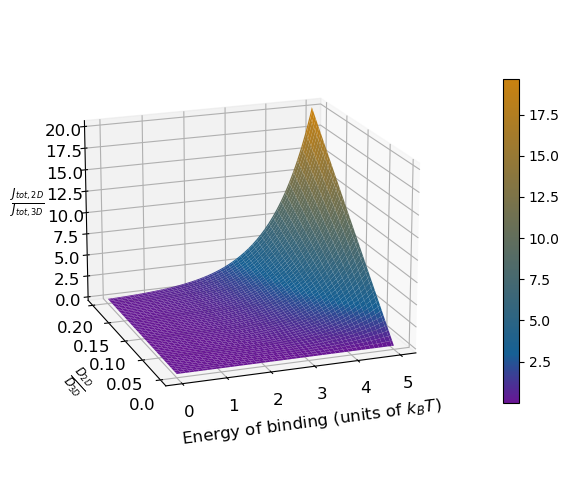

In [44]:
a=1.E-6
s=1.E-8
d=1.E-8
N = 100
kBT = 4.E-21

from matplotlib.colors import LinearSegmentedColormap

##Plot the time to capture for moving receptors##
Ea_arr = np.linspace(0.,5.,100)
ratio_D_arr = np.linspace(0.,0.2,100)
def ratio(Ea,ratio_D):
    return ratio_D*np.pi*d*np.exp(Ea)/(s*np.log((a**2)/(N*s**2)))
Ea_arr, ratio_D_arr = np.meshgrid(Ea_arr, ratio_D_arr)
ratio_values = ratio(Ea_arr, ratio_D_arr)

##Initialize figure##
current_directory = os.getcwd()
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
color_arr = ['#681694','#166094','#169431','#c98210']
colors = [(0.0, color_arr[0]), (0.15, color_arr[1]), (1.0, color_arr[3])]
pers_cmap = LinearSegmentedColormap.from_list('pers_cmap', colors)
surf = ax.plot_surface(Ea_arr, ratio_D_arr, ratio_values, cmap=pers_cmap)

# Set point of view
ax.view_init(elev=18, azim=-110)
# Add labels and a colorbar
ax.set_xlabel('Energy of binding (units of $k_B T$)', fontsize=12, labelpad=12)
ax.set_ylabel(r'$\frac{D_{2D}}{D_{3D}}$', fontsize=12, labelpad=12)
ax.zaxis.set_rotate_label(False)
z_label = ax.set_zlabel(r'$\frac{J_{tot,2D}}{J_{tot,3D}}$', fontsize=12, rotation=0, labelpad=12)
#ax.set_xlim(5., 500.)
#ax.set_ylim(0.0, 1.5E-3)
ax.dist = 11.5
ax.set_position([-0.1, 0.1, 1., 1.])
fig.colorbar(surf, shrink=0.7)

# Adjust tick positions and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=5)
labels_y=[r'$0.0$',r'$0.05$',r'$0.10$',r'$0.15$',r'0.20']
locs_y=[0,0.05,0.1,0.15,0.2]
ax.set_yticks(locs_y)
ax.set_yticklabels(labels_y)
##Save figure##
ax.tick_params(labelsize=12,direction='in',which='minor',bottom=True, top=False, left=True, right=False,length=3 ) 
ax.tick_params(labelsize=12,direction='in',which='major',bottom=True, top=False, left=True, right=False,length=6 )
ax.legend(fancybox=True, shadow=True, ncol=1, fontsize=12,columnspacing=1.,scatterpoints=1,handletextpad=0.2,handlelength=0.8,frameon=False)
os.chdir(current_directory)
name_file_save='ratio'+'.pdf'
fig.set_size_inches(8, 6)
fig.savefig(name_file_save, dpi=300, bbox_inches="tight",transparent=True)
os.chdir(current_directory)
fig.show()

## Active movement of the cell ##
The cell is also able to move inside the cell. This effect occurs at low Reynold's number $Re = \frac{\rho v L}{\mu}$ due to the small size of the cell.
### Effects of stirring ###
By stirring the fluid close to the cell, the concentration of molecules near the surface can be increased. Close to the cell's surface, the concentration is only dictated by diffusion, so that $\frac{\partial }{\partial r}\left(r^2 \frac{\partial c}{\partial r}\right) = 0$, and thus:

\begin{equation*}
    c(r)=c_{\infty}(1-\frac{a}{r})
\end{equation*}

With stirring within radiuses $r_1$ and $r_2$ ($r_1 < r_2$) happening infinitely fast, the concentration at $r_1$ can be equal to that of $r_2$. This corresponds to an effective value of $c_{\infty}$, labelled $\tilde{c}_{\infty}$:

\begin{equation*}
    \tilde{c}_{\infty}(1-\frac{a}{r_1})=c_{\infty}(1-\frac{a}{r_2}) \, \Rightarrow \, r_1 = \frac{\frac{\tilde{c}_{\infty}}{c_{\infty}}a r_2}{a+(\frac{\tilde{c}_{\infty}}{c_{\infty}}-1)r_2}
\end{equation*}

### Hydrodynamics of the stirring ###
We start from an irrotational velocity field with uniform shearing stress:

\begin{equation*}
    \bm{v_0}(\bm{r})=\frac{1}{2}\Omega(\bm{x}y+\bm{y}x)
\end{equation*}

We immerge a spherical particle of radius $a$ inside this fluid and study the flow around the particle. The flow is the solution of the Stokes' equations (here the Reynold's number is small compared to 1 and we consider a viscous flow):

\begin{equation*}
\begin{split}
    \nabla \cdot \bm{v} &= 0
    \\ \eta \nabla^2\left(\nabla \times \bm{v}\right) &= 0
\end{split}
\end{equation*}

The boundary conditions are:
\begin{equation*}
\begin{split}
    \left.\bm{v}\right|_{r=a} &= 0
    \\ \left.\bm{v}\right|_{r=\infty} &= \bm{v_0}
\end{split}
\end{equation*}

If we consider spherical coordinates centered at the center of the particle

### Can swimming improve the reception of the cell ? ###

# Signal transmission and chemotaxis #
We consider the occupation function of a given receptor $p(t)$ which value is $1$ if the site is occupied and $0$ otherwise. The time average of this quantity is $\bar{p}(t)$, where the average is performed over a time $T$. According to the article, chemotaxis should depend on the ability of a bacteria to detect the variation of this value in time.
We can consider a model for bacterial chemotaxis towards receptors. The bacteria follows a run & tumble motion, which corresponds to a random walk if there is no bias. However we consider the more general linear response to a time variation in the fraction of receptors, a convolution modifying the mean run time:
\begin{equation*}
\begin{split}
    \frac{1}{\tau_r} &= \frac{1}{\tau_0}-\int_0^{t}dt'R(t-t')\frac{ \partial \bar{p}}{\partial t'}(t')\\
    &=\frac{1}{\tau_0}-\int_0^{t}dt'R(t-t')\frac{\partial}{\partial t'}(\frac{1}{T}\int_{t'}^{t'+T}dt''p(t''))
\end{split}
\end{equation*}

The probability of occupation is given by the equation:

\begin{equation*}
    \frac{\partial p}{\partial t} = -\frac{p(t)}{\tau_b} + \beta(1-p(t))
\end{equation*}

Where $\frac{1}{\tau_b}$ is the probability of leaving the site per unit time and $\beta$ the probability of binding per unit time. Then with:

\begin{equation*}
    \frac{\partial}{\partial t'}(\frac{1}{T}\int_{t'}^{t'+T}dt''p(t'')) = \frac{p(t'+T)-p(t')}{T} = \frac{\beta}{T}\frac{1-\exp(-T(\frac{1}{\tau_b}+\beta))}{\frac{1}{\tau_b}+\beta}\exp(-t'(\frac{1}{\tau_b}+\beta))
\end{equation*}

If we consider a gaussian response function $R(t)=\frac{\theta_H (t)}{\sqrt{2\pi \sigma^2}} \exp(-\frac{t^2}{2\sigma^2})$, we find by approximating $\int_0^{t}dt'R(t-t')\frac{\partial \bar{p}}{\partial t'}(t')$ by $\int_0^{\infty}dt'R(t-t')\frac{\partial \bar{p}}{\partial t'}(t')$, which is justified by the fact the the response function is peaked:

\begin{equation*}
\begin{split}
    \frac{1}{\tau_r} &= \frac{1}{\tau_0}-\frac{\beta}{T}\frac{1-\exp(-T(\frac{1}{\tau_b}+\beta))}{\frac{1}{\tau_b}+\beta}\exp\left(-(\frac{1}{\tau_b}+\beta)^2\frac{\sigma^2}{2}\right)
    \\ &\simeq \frac{1}{\tau_0}-\beta
\end{split}
\end{equation*}

Where the last equality is true in the limit $T \to 0$ and $\sigma \to 0$.

/tmp/ipykernel_159343/562043075.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


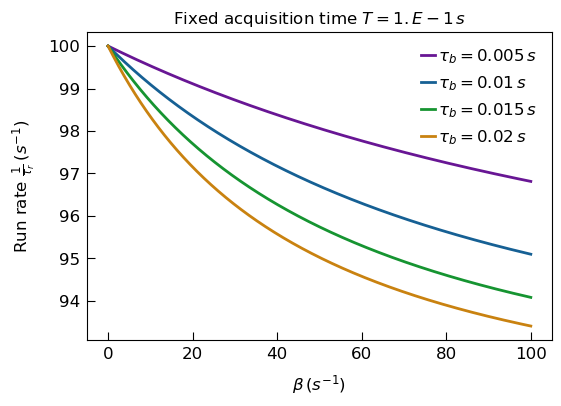

In [53]:
def k_run (tau_0,T,sigma,tau_b,beta):
    rate = (1/tau_b + beta)
    return 1/tau_0 - (beta/T)*(1-np.exp(-T*rate))*np.exp(-(sigma**2/2.)*rate**2)/rate

##Initialize figure##
current_directory = os.getcwd()
# Create a figure and axis  
fig, ax = plt.subplots()
# Set axes
ax.set_xlabel(r'$\beta\,(s^{-1})$',fontsize=12,labelpad=8)
ax.set_ylabel(r'Run rate $\frac{1}{\tau_r}\,(s^{-1})$',fontsize=12,labelpad=8)
##Plot##
color_arr = ['#681694','#166094','#169431','#c98210']
for i,tau_b in enumerate([5.E-3,1.E-2,1.5E-2,2.E-2]):
    beta_array = np.linspace(0.,1.E2,1000)
    k_array = k_run(1.E-2,1.E-1,1.E-3,tau_b,beta_array)
    ax.plot(beta_array , k_array, c=color_arr[i], label=r'$\tau_b = {}$'.format(tau_b)+r'$\,s$', lw=2, zorder=2)
# Adjust tick positions and labels
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=5)
##Save figure##
ax.set_title(r'Fixed acquisition time $T=1.E-1\,s$')
ax.tick_params(labelsize=12,direction='in',which='minor',bottom=True, top=False, left=True, right=False,length=3 ) 
ax.tick_params(labelsize=12,direction='in',which='major',bottom=True, top=False, left=True, right=False,length=6 )
ax.legend(fancybox=True, shadow=True, ncol=1, fontsize=12,columnspacing=1.,scatterpoints=1,handletextpad=0.2,handlelength=0.8,frameon=False)
os.chdir(current_directory)
name_file_save='run_time'+'.pdf'
fig.set_size_inches(6, 4)
fig.savefig(name_file_save, dpi=300, bbox_inches="tight",transparent=True)
os.chdir(current_directory)
fig.show()

In particular, if we fix the acquisition time we observe that the run rate decreases when the rate $\frac{1}{\tau_b}$ at which molecules leave the binding sites decreases and when the rate at which they bind $\beta$ increases. Ths means that the longer the molecules are bound to the receptors, the longer the runs are. And the more molecules bind per unit time, the longer the runs are.

Now we can study the dependency in the acquisition time $T$, fixing the rate $\frac{1}{\tau_b}$.

/tmp/ipykernel_159343/1781214678.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


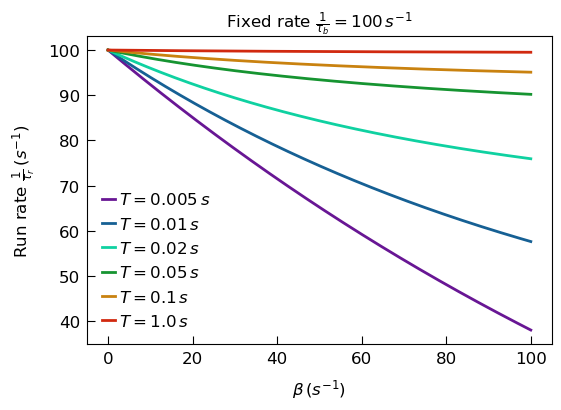

In [51]:
def k_run (tau_0,T,sigma,tau_b,beta):
    rate = (1/tau_b + beta)
    return 1/tau_0 - (beta/T)*(1-np.exp(-T*rate))*np.exp(-(sigma**2/2.)*rate**2)/rate

##Initialize figure##
current_directory = os.getcwd()
# Create a figure and axis  
fig, ax = plt.subplots()
# Set axes
ax.set_xlabel(r'$\beta\,(s^{-1})$',fontsize=12,labelpad=8)
ax.set_ylabel(r'Run rate $\frac{1}{\tau_r}\,(s^{-1})$',fontsize=12,labelpad=8)
##Plot##
color_arr = ['#681694','#166094','#0fd1a1','#169431','#c98210','#d1290f']
for i,T in enumerate([5.E-3,1.E-2,2.E-2,5.E-2,1.E-1,1.]):
    beta_array = np.linspace(0.,1.E2,1000)
    k_array = k_run(1.E-2,T,1.E-3,1.E-2,beta_array)
    ax.plot(beta_array , k_array, c=color_arr[i], label=r'$T={}$'.format(T)+r'$\,s$', lw=2, zorder=2)
# Adjust tick positions and labels
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=5)
##Save figure##
ax.set_title(r'Fixed rate $\frac{1}{\tau_b}=100\,s^{-1}$')
ax.tick_params(labelsize=12,direction='in',which='minor',bottom=True, top=False, left=True, right=False,length=3 ) 
ax.tick_params(labelsize=12,direction='in',which='major',bottom=True, top=False, left=True, right=False,length=6 )
ax.legend(fancybox=True, shadow=True, ncol=1, fontsize=12,columnspacing=1.,scatterpoints=1,handletextpad=0.2,handlelength=0.8,frameon=False)
os.chdir(current_directory)
name_file_save='run_time_fixd_rate'+'.pdf'
fig.set_size_inches(6, 4)
fig.savefig(name_file_save, dpi=300, bbox_inches="tight",transparent=True)
os.chdir(current_directory)
fig.show()

As we can see the result depends strongly on the acquisition rate. A small acquisition time (lower or of the order of the characteristic times of the system) leads to a stronger dependency on the rates, the information is instantaneous and we recover the linear behaviour $\frac{1}{\tau_b}=\frac{1}{\tau_0}-\beta$. On the contrary, a long time of acquisition (several order of magnitude larger than the characteristic times) leads to averaging the informations and decreasing the dependency of the system on the parameter $\beta$.

If we suppose that the run time is only modified in the direction where the bacteria can sense the information $\frac{d \bar{p}}{d t}$ (towards the cell), the movement of the bacteria will be biased towards the cell because it will perform longer runs in these directions. To make this quantitative we can consider that the information comes also from a spatial gradient of concentration rather than only by $\frac{\partial \bar{p}}{\partial t}$. In this case we can consider a run time of the form:

\begin{equation*}
\begin{split}
    \frac{1}{\tau_r} &= \frac{1}{\tau_0}\left(1-\int_0^{t}dt'R_s(t-t')(\vec{V}t')\cdot\nabla c\right) -\int_0^{t}dt'R_t(t-t') \frac{\partial \bar{p}}{\partial t}(t')
\end{split}
\end{equation*}

Where $\vec{V}$ is the velocity of the bacteria during the run rate. If we suppose that $R_t(t)$ is still a gaussian and $R_s(t)$ is a dirac delta $R_s(t)=\rho \delta(t-\Delta)$ where $\Delta$ is the delay to process the information. We note $\Pi(\tau)$ the probability that the run lasts at least $\tau$ is given by :

\begin{equation*}
    \frac{d \Pi}{d \tau}(\tau) = -\frac{\Pi(\tau)}{\tau_r}
\end{equation*}

If we take the limit where the acquisition time $T$ and $\sigma$ go to $0$, and consider $\tau>\Delta$, we get:

\begin{equation*}
    \frac{d \Pi}{d \tau}(\tau) = -\Pi(\tau)\left(\frac{1}{\tau_0}\left(1-\rho\vec{V}\cdot\nabla c(\tau-\Delta)\right)-\beta\right)
\end{equation*}

Therefore:

\begin{equation*}
\begin{split}
    \Pi(\tau) &= \exp\left(-\left(\frac{1}{\tau_0}-\beta\right)\tau\right)\exp\left(\frac{\rho}{2\tau_0}\vec{V}\cdot\nabla c(\tau-\Delta)^2\right) \\
    & \simeq \exp\left(-\frac{1}{\tau_0}\tau\right)\left(1+\beta\tau+\frac{\rho}{2\tau_0}\vec{V}\cdot\nabla c(\tau-\Delta)^2\right)
\end{split}
\end{equation*}

The probability to end a run between $\tau$ and $\tau + d\tau$ is $\pi(\tau) d\tau = -\frac{d\Pi}{d\tau}(\tau) d\tau$. Therefore the mean displacement at a given speed $V$ during a run phase is:

\begin{equation}
    \vec{x}_m = \int d\tau \vec{V} \tau \pi(\tau) = \vec{V} \int d\tau \Pi(\tau)
\end{equation}

Where the second equality comes from an integration by parts. Thus:

\begin{equation}
    \vec{x}_m = \vec{V} \left(\tau_0 + \beta \tau_0^2 + \rho\tau_0\vec{V}\cdot\nabla c e^{-\frac{\Delta}{\tau_0}}\right)
\end{equation}

Now if we consider that the direction of the velocity is random ($<\vec{V}> = \mathbf{0}$), then:

\begin{equation}
    <\vec{x}_m> = \rho\tau_0e^{-\frac{\Delta}{\tau_0}}<\vec{V} (\vec{V}\cdot\nabla c)>
\end{equation}